In [2]:
import numpy as np
#
# Import necessary libraries
from numerapi import SignalsAPI
import pandas as pd

# Train/test split (same split used for all targets)
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score
import joblib
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
api = SignalsAPI()
api.download_dataset(
	"signals/v2.0/train.parquet",
	"train.parquet"
)
api.download_dataset(
	"signals/v2.0/validation.parquet",
	"validation.parquet"
)
api.download_dataset(
	"signals/v2.0/live.parquet",
	"live.parquet"
)

In [ ]:
# you can also use other libraries like xgboost, catboost, etc.
# you need to train.parquet and test.parquet files
df_train = pd.read_parquet("train.parquet")
df_val = pd.read_parquet("validation.parquet")

# drop rows with too many missing values
max_allowed_nans = 5  # adjust as needed
feature_cols = [col for col in df_train.columns if col.startswith("feature_")]

df_train_clean = df_train[df_train[feature_cols].isna().sum(axis=1) < max_allowed_nans]
df_val_clean = df_val[df_val[feature_cols].isna().sum(axis=1) < max_allowed_nans]

# we are going to clean stuff up here
df_train_clean = df_train.dropna(subset=feature_cols).copy()
df_val_clean = df_val.dropna(subset=feature_cols).copy()

# define what feature columns we want to use
feature_cols = [col for col in df_train_clean.columns if col.startswith("feature_")]
feature_cols.remove("feature_country")

# first create some mean features for reference
for feature in feature_cols:
    df_train_clean[f"{feature}_mean"] = (
        df_train_clean
        .groupby(["date", "feature_country"])[feature]
        .transform("mean")
    )
    df_val_clean[f"{feature}_mean"] = (
        df_val_clean
        .groupby(["date", "feature_country"])[feature]
        .transform("mean")
    )
# now that we have some mean features, we can either
# create lagged features or use delta features
# here I am going to create delta features
for feature in feature_cols:
    df_train_clean[f"{feature}_delta"] = (
        df_train_clean[feature] - df_train_clean[f"{feature}_mean"])
    df_val_clean[f"{feature}_delta"] = (
        df_val_clean[feature] - df_val_clean[f"{feature}_mean"])

# now you CAN create Lagged features if you want
# We will add some lagging features (I am going small because I don't
# want to create too many features)
"""
for feature in feature_cols:
    for lag in [1, 3]:
        df_train_clean[f"{feature}_lag{lag}"] = (
            df_train_clean
            .groupby("numerai_ticker")[feature]
            .shift(lag)
        )
        df_val_clean[f"{feature}_lag{lag}"] = (
            df_val_clean
            .groupby("numerai_ticker")[feature]
            .shift(lag)
        )
"""

'\nfor feature in feature_cols:\n    for lag in [1, 3]:\n        df_train_clean[f"{feature}_lag{lag}"] = (\n            df_train_clean\n            .groupby("numerai_ticker")[feature]\n            .shift(lag)\n        )\n        df_val_clean[f"{feature}_lag{lag}"] = (\n            df_val_clean\n            .groupby("numerai_ticker")[feature]\n            .shift(lag)\n        )\n'

In [29]:
K = 3  # Number of early rows to drop per ticker

def drop_first_k_per_ticker(df, ticker_col='numerai_ticker', date_col='date'):
    df_sorted = df.sort_values([ticker_col, date_col])
    return df_sorted.groupby(ticker_col).apply(lambda g: g.iloc[K:]).reset_index(drop=True)

df_train_clean = drop_first_k_per_ticker(df_train_clean)
df_val_clean = drop_first_k_per_ticker(df_val_clean)

C:\Users\jorda\AppData\Local\Temp\ipykernel_8876\3372031683.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_sorted.groupby(ticker_col).apply(lambda g: g.iloc[K:]).reset_index(drop=True)
C:\Users\jorda\AppData\Local\Temp\ipykernel_8876\3372031683.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_sorted.groupby(ticker_col).apply(lambda g: g.iloc[K:]).reset_index(drop=True)


In [30]:
# redefine Feature and target columns
feature_columns = [col for col in df_train_clean.columns if col.startswith("feature_")]
target_columns = [col for col in df_train_clean.columns if col.startswith("target_")]
feature_columns.remove("feature_country")

print("Feature columns:", feature_columns)

Feature columns: ['feature_adv_20d_factor', 'feature_beta_factor', 'feature_book_to_price_factor', 'feature_dividend_yield_factor', 'feature_earnings_yield_factor', 'feature_growth_factor', 'feature_impact_cost_factor', 'feature_market_cap_factor', 'feature_momentum_12w_factor', 'feature_momentum_26w_factor', 'feature_momentum_52w_factor', 'feature_momentum_52w_less_4w_factor', 'feature_ppo_60d_130d_country_ranknorm', 'feature_ppo_60d_90d_country_ranknorm', 'feature_price_factor', 'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm', 'feature_rsi_90d_country_ranknorm', 'feature_trix_130d_country_ranknorm', 'feature_trix_60d_country_ranknorm', 'feature_value_factor', 'feature_volatility_factor', 'feature_adv_20d_factor_mean', 'feature_beta_factor_mean', 'feature_book_to_price_factor_mean', 'feature_dividend_yield_factor_mean', 'feature_earnings_yield_factor_mean', 'feature_growth_factor_mean', 'feature_impact_cost_factor_mean', 'feature_market_cap_factor_mean', 'featu

In [31]:
df_train_clean = df_train_clean.dropna(subset=target_columns).copy()
df_val_clean = df_val_clean.dropna(subset=target_columns).copy()

In [32]:
print(df_train_clean["date"].unique())

<StringArray>
['2009-05-29', '2009-06-05', '2009-06-12', '2009-07-17', '2009-07-24',
 '2009-07-31', '2009-08-07', '2009-08-14', '2009-08-21', '2009-08-28',
 ...
 '2004-05-14', '2004-05-21', '2004-05-28', '2004-06-04', '2004-06-11',
 '2004-06-18', '2004-07-02', '2004-07-09', '2004-07-16', '2004-06-25']
Length: 466, dtype: string


In [37]:
import pandas as pd
from pandas import to_datetime

In [39]:
df_train_clean["date"] = pd.to_datetime(df_train_clean["date"])
df_train_clean = df_train_clean.sort_values("date")
split_date = pd.to_datetime("2007-02-01")

In [40]:
df_train_temporal = df_train_clean[df_train_clean["date"] < split_date].copy()
df_val_temporal   = df_train_clean[df_train_clean["date"] >= split_date].copy()

In [ ]:
for target in target_columns:
    print(f"\nTraining model for {target}...")

    #X_train = df_train_clean[feature_columns]
    #y_train = df_train_clean[target]
    X_train = df_train_temporal[feature_columns]
    y_train = df_train_temporal[target]

    X_val = df_val_temporal[feature_columns]
    y_val = df_val_temporal[target]

    model = LGBMRegressor(
        n_estimators=100,
        verbosity=-1,
        random_state=42
    )
    """
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        num_leaves=31,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        verbosity=-1
    )
    """
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    #print(y_pred[:5])
    print(f"{target}: y_val NaNs = {y_val.isna().sum()}, y_pred NaNs = {np.isnan(y_pred).sum()}")

    # Score
    spearman = spearmanr(y_val, y_pred).correlation
    print(f"{target}: Spearman = {spearman:.4f}")

    # Save
    joblib.dump(model, f"lgbm_model_{target}.pkl")
    print(f"Saved model for {target}")


Training model for target_raw_return_20...
target_raw_return_20: y_val NaNs = 0, y_pred NaNs = 0
target_raw_return_20: Spearman = 0.0025
Saved model for target_raw_return_20

Training model for target_raw_return_60...
target_raw_return_60: y_val NaNs = 0, y_pred NaNs = 0
target_raw_return_60: Spearman = 0.0297
Saved model for target_raw_return_60

Training model for target_factor_neutral_20...
target_factor_neutral_20: y_val NaNs = 0, y_pred NaNs = 0
target_factor_neutral_20: Spearman = 0.0153
Saved model for target_factor_neutral_20

Training model for target_factor_neutral_60...
target_factor_neutral_60: y_val NaNs = 0, y_pred NaNs = 0
target_factor_neutral_60: Spearman = 0.0197
Saved model for target_factor_neutral_60

Training model for target_factor_feat_neutral_20...
target_factor_feat_neutral_20: y_val NaNs = 0, y_pred NaNs = 0
target_factor_feat_neutral_20: Spearman = 0.0058
Saved model for target_factor_feat_neutral_20

Training model for target_factor_feat_neutral_60...
targ

In [42]:
# List of targets and their Spearman scores
target_spearman_scores = {
    "target_raw_return_20": 0.0025,
    "target_raw_return_60": 0.0297,
    "target_factor_neutral_20": 0.0153,
    "target_factor_neutral_60": 0.0197,
    "target_factor_feat_neutral_20": 0.0058,
    "target_factor_feat_neutral_60": 0.0094,
    "target_camille_20": 0.0066,
    "target_camille_60": 0.0055,
    "target_sydney_20": 0.0054,
    "target_sydney_60": 0.0076,
    "target_irina_20": 0.0102,
    "target_irina_60": 0.0169,
    "target_alexandra_20": 0.0019,
    "target_alexandra_60": 0.0161,
    "target_colleen_20": 0.0031,
    "target_colleen_60": 0.0039,
    "target_jean_20": 0.0014,
    "target_jean_60": 0.0170,
    "target_eleven_4": 0.0038,
    "target_eleven_20": 0.0060,
    "target_eleven_60": 0.0078,
}

# Step 2: Convert to Series and apply exponential weighting
alpha = 2  # You can try 3 or 4 to emphasize top performers more
spearman_series = pd.Series(target_spearman_scores)
weights = np.power(spearman_series, alpha)
weights /= weights.sum()

# Generate predictions for each model
for target in target_spearman_scores:
    model = joblib.load(f"lgbm_model_{target}.pkl")
    df_val_clean[f"signal_{target}"] = model.predict(df_val_clean[feature_columns])

# Combine signals with weights into one final signal
signal_cols = [f"signal_{target}" for target in target_spearman_scores]
df_val_clean["signal"] = sum(
    df_val_clean[f"signal_{target}"] * weight
    for target, weight in weights.items()
)

# Create final submission DataFrame
df_val_check2 = df_val_clean[["numerai_ticker", "date", "signal"]].copy()

# Optional: sort by ticker
df_val_check2.sort_values("numerai_ticker", inplace=True)

# Save submission file
df_val_check2.to_csv("sharpe_check_cooked.csv", index=False)

# print out a historgram of signal values

In [43]:
import matplotlib.pyplot as plt

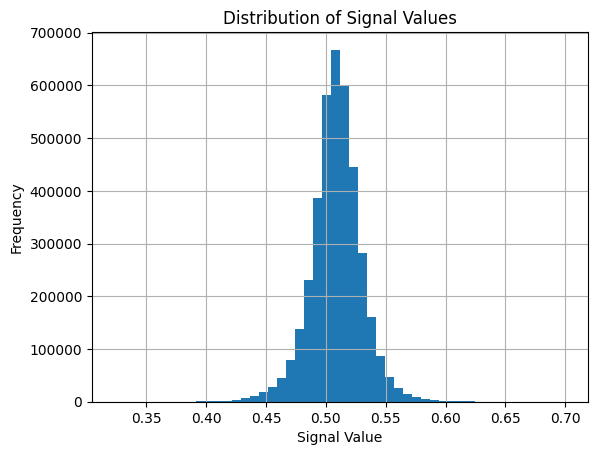

In [44]:
df_val_check2["signal"].hist(bins=50)
plt.title("Distribution of Signal Values")
plt.xlabel("Signal Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [45]:
from sklearn.preprocessing import MinMaxScaler
df_val_check2["signal"] = MinMaxScaler().fit_transform(df_val_check2["signal"].values.reshape(-1, 1)).flatten()

In [47]:
# Save submission file
df_val_check2.to_csv("sharpe_check_cooked.csv", index=False)

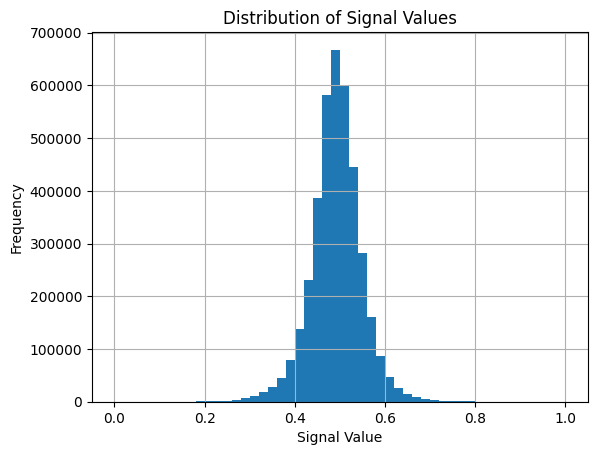

In [48]:
df_val_check2["signal"].hist(bins=50)
plt.title("Distribution of Signal Values")
plt.xlabel("Signal Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Now we make out predictions to submit

In [15]:
df_val_end = pd.read_parquet("validation.parquet")

In [24]:
df_live = pd.read_parquet("live.parquet")
feature_cols = [col for col in df_live.columns if col.startswith("feature_")]
feature_cols.remove("feature_country")
df_live = df_live.dropna(subset=feature_cols).copy()

"""
last_3_dates = df_val_end["date"].drop_duplicates().sort_values().tail(3).tolist()
df_recent = df_val_end[df_val_end["date"].isin(last_3_dates)].copy()
df_combined = pd.concat([df_recent, df_live], axis=0)
df_combined = df_combined.sort_values(["numerai_ticker", "date"])
"""

'\nlast_3_dates = df_val_end["date"].drop_duplicates().sort_values().tail(3).tolist()\ndf_recent = df_val_end[df_val_end["date"].isin(last_3_dates)].copy()\ndf_combined = pd.concat([df_recent, df_live], axis=0)\ndf_combined = df_combined.sort_values(["numerai_ticker", "date"])\n'

In [14]:
# print(df_live.head(1))

In [25]:
# first create some mean features for reference
for feature in feature_cols:
    df_live[f"{feature}_mean"] = (
        df_live
        .groupby(["date", "feature_country"])[feature]
        .transform("mean")
    )
    df_live[f"{feature}_mean"] = (
        df_live
        .groupby(["date", "feature_country"])[feature]
        .transform("mean")
    )
# now that we have some mean features, we can either
# create lagged features or use delta features
# here I am going to create delta features
for feature in feature_cols:
    df_live[f"{feature}_delta"] = (
        df_live[feature] - df_live[f"{feature}_mean"])
    df_live[f"{feature}_delta"] = (
        df_live[feature] - df_live[f"{feature}_mean"])
"""    
for feature in feature_cols:
    for lag in [1, 3]:
        df_live[f"{feature}_lag{lag}"] = (
            df_live
            .groupby("numerai_ticker")[feature]
            .shift(lag)
        )
        df_live[f"{feature}_lag{lag}"] = (
            df_live
            .groupby("numerai_ticker")[feature]
            .shift(lag)
        )
"""


'    \nfor feature in feature_cols:\n    for lag in [1, 3]:\n        df_live[f"{feature}_lag{lag}"] = (\n            df_live\n            .groupby("numerai_ticker")[feature]\n            .shift(lag)\n        )\n        df_live[f"{feature}_lag{lag}"] = (\n            df_live\n            .groupby("numerai_ticker")[feature]\n            .shift(lag)\n        )\n'

In [28]:
feature_cols = [col for col in df_live.columns if col.startswith("feature_")]
feature_cols.remove("feature_country")

In [19]:
live_date = df_live["date"].iloc[0]
print(f"Live date: {live_date}")

Live date: 2025-07-15


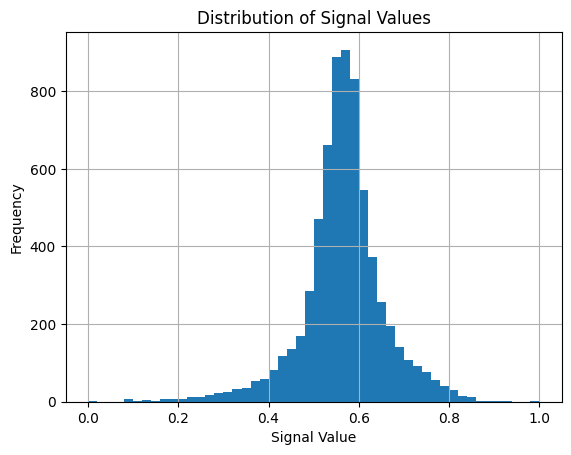

In [33]:
target_spearman_scores = {
    "target_raw_return_20": 0.0025,
    "target_raw_return_60": 0.0297,
    "target_factor_neutral_20": 0.0153,
    "target_factor_neutral_60": 0.0197,
    "target_factor_feat_neutral_20": 0.0058,
    "target_factor_feat_neutral_60": 0.0094,
    "target_camille_20": 0.0066,
    "target_camille_60": 0.0055,
    "target_sydney_20": 0.0054,
    "target_sydney_60": 0.0076,
    "target_irina_20": 0.0102,
    "target_irina_60": 0.0169,
    "target_alexandra_20": 0.0019,
    "target_alexandra_60": 0.0161,
    "target_colleen_20": 0.0031,
    "target_colleen_60": 0.0039,
    "target_jean_20": 0.0014,
    "target_jean_60": 0.0170,
    "target_eleven_4": 0.0038,
    "target_eleven_20": 0.0060,
    "target_eleven_60": 0.0078,
}

# Step 2: Convert to Series and apply exponential weighting
alpha = 2  # You can try 3 or 4 to emphasize top performers more
spearman_series = pd.Series(target_spearman_scores)
weights = np.power(spearman_series, alpha)
weights /= weights.sum()

# Generate predictions for each model
for target in target_spearman_scores:
    model = joblib.load(f"lgbm_model_{target}.pkl")
    df_live[f"signal_{target}"] = model.predict(df_live[feature_cols])

# Combine signals with weights into one final signal
signal_cols = [f"signal_{target}" for target in target_spearman_scores]
df_live["signal"] = sum(
    df_live[f"signal_{target}"] * weight
    for target, weight in weights.items()
)

# Create final submission DataFrame
df_live_submit = df_live[["numerai_ticker", "date", "signal", "data_type"]].copy()

# Optional: sort by ticker
df_live_submit.sort_values("numerai_ticker", inplace=True)

df_live_submit["signal"] = MinMaxScaler().fit_transform(df_live_submit["signal"].values.reshape(-1, 1)).flatten()

df_live_submit["signal"].hist(bins=50)
plt.title("Distribution of Signal Values")
plt.xlabel("Signal Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [34]:
df_live_submit.to_csv("todays_submission.csv", index=False)

In [35]:
print(df_live_submit)

     numerai_ticker        date    signal data_type
0         000070 KR  2025-07-15  0.561070      live
1         000080 KR  2025-07-15  0.508074      live
2         000100 KR  2025-07-15  0.430356      live
3         000120 KR  2025-07-15  0.530924      live
4         000150 KR  2025-07-15  0.391484      live
...             ...         ...       ...       ...
7008        ZUMZ US  2025-07-15  0.516587      live
7009        ZURN CH  2025-07-15  0.563348      live
7010        ZVRA US  2025-07-15  0.609586      live
7011         ZWS US  2025-07-15  0.502103      live
7012        ZYME US  2025-07-15  0.578565      live

[6801 rows x 4 columns]
